# Initialization

## Load Packages

In [2]:
import os
import random
from pathlib import Path
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torchvision.transforms as T
from dotenv import load_dotenv

from datasets import load_dataset
from torchvision.utils import save_image

from diffusers import DDPMPipeline, AutoencoderKL
from transformers import pipeline
import torch.nn.functional as F

# Set modern seaborn theme
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## Configuration and Environments

In [3]:
load_dotenv()

# Configuration parameters
CONFIG = {
    'project_name': 'synthetic_image_eval',
    'seed': 42,
    'n_real_images': 1000,  # Parameterized for easy adjustment
    'n_generated_per_model': 500,
    'image_size': 128,  # Using 128x128 for better quality evaluation
    'data_dir': os.getenv('DATA_DIR', './data'),  # From .env file
    'batch_size': 16,
}

# Create project directory structure
PROJECT_DIR = Path(CONFIG['data_dir']) / CONFIG['project_name']
DIRS = {
    'real': PROJECT_DIR / 'real_images',
    'gan': PROJECT_DIR / 'gan_generated',
    'diffusion': PROJECT_DIR / 'diffusion_generated',
    'toy': PROJECT_DIR / 'toy_example',
}

for dir_path in DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)


## Reproducibility Setup

In [4]:
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility across all libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG['seed'])
print(f"✓ Random seed set to {CONFIG['seed']}")

✓ Random seed set to 42


## Device Config

In [5]:
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✓ Using device: {device}")

✓ Using device: mps


## Utility Functions

In [6]:
def clean_directory(dir_path: Path, pattern: str = "*"):
    """
    Clean a directory by removing all files matching the pattern.
    Useful for ensuring fresh runs without stale cached images.
    
    Args:
        dir_path: Directory to clean
        pattern: File pattern to match (default: all files)
    """
    if dir_path.exists():
        files = list(dir_path.glob(pattern))
        if files:
            print(f"  Cleaning {len(files)} files from {dir_path.name}/")
            for file in files:
                file.unlink()
            return len(files)
    return 0

def save_image_grid(images: List[Image.Image], save_path: Path, nrow: int = 3):
    """Save a grid of images for visualization."""
    n = len(images)
    ncol = (n + nrow - 1) // nrow
    
    fig, axes = plt.subplots(ncol, nrow, figsize=(nrow * 3, ncol * 3))
    axes = axes.flatten() if n > 1 else [axes]
    
    for idx, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        ax.axis('off')
    
    for ax in axes[n:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()

# Dataset Preparation

## Load CelebA-HQ Dataset

In [7]:
try:
    dataset = load_dataset("nielsr/CelebA-faces", split="train", trust_remote_code=True)
    print(f"✓ Dataset loaded successfully")
    print(f"  Total images available: {len(dataset)}")
    print(f"  Native resolution: 178x178 pixels")
    print(f"  Will be resized to: {CONFIG['image_size']}x{CONFIG['image_size']} pixels")
except Exception as e:
    raise RuntimeError(f"Could not load CelebA-faces dataset: {e}\nPlease check your internet connection or HuggingFace access.")


`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'nielsr/CelebA-faces' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


✓ Dataset loaded successfully
  Total images available: 202599
  Native resolution: 178x178 pixels
  Will be resized to: 128x128 pixels


## Create a Fixed Subset of Real Images

In [8]:
print("\nChecking for existing images...")
n_cleaned = clean_directory(DIRS['real'], "*.png")
if n_cleaned > 0:
    print(f"✓ Cleaned {n_cleaned} existing images")
else:
    print("✓ Directory is clean")

# Set seed for reproducible subset selection
set_seed(CONFIG['seed'])

# Randomly sample n_real_images from dataset
n_available = len(dataset)
n_to_sample = min(CONFIG['n_real_images'], n_available)
indices = random.sample(range(n_available), n_to_sample)

print(f"\nCreating fixed subset of {n_to_sample} real images...")

# Define image transformation pipeline
transform = T.Compose([
    T.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    T.ToTensor(),
])

# Extract and save real images
real_images = []
for idx, dataset_idx in enumerate(indices):
    # Get image from dataset (nielsr/CelebA-faces uses 'image' key)
    image = dataset[dataset_idx]['image']
    
    # Convert to PIL Image if needed
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image) if isinstance(image, np.ndarray) else image
    
    # Convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Resize to target size using high-quality Lanczos resampling
    image = image.resize((CONFIG['image_size'], CONFIG['image_size']), Image.Resampling.LANCZOS)
    
    # Save image
    save_path = DIRS['real'] / f"real_{idx:04d}.png"
    image.save(save_path)
    real_images.append(image)
    
    if (idx + 1) % 100 == 0:
        print(f"  Processed {idx + 1}/{n_to_sample} images")


Checking for existing images...
  Cleaning 1000 files from real_images/
✓ Cleaned 1000 existing images

Creating fixed subset of 1000 real images...
  Processed 100/1000 images
  Processed 200/1000 images
  Processed 300/1000 images
  Processed 400/1000 images
  Processed 500/1000 images
  Processed 600/1000 images
  Processed 700/1000 images
  Processed 800/1000 images
  Processed 900/1000 images
  Processed 1000/1000 images


## Visualize Real Images

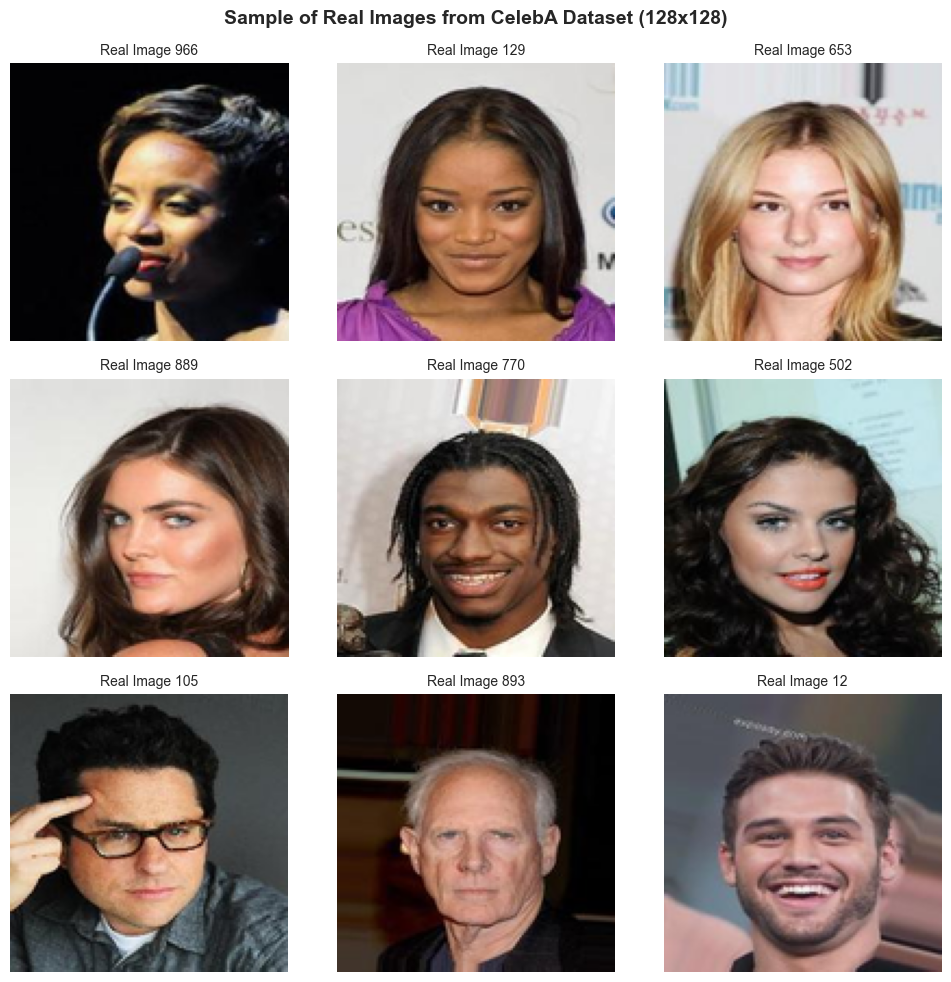

In [9]:
sample_indices = random.sample(range(len(real_images)), 9)
sample_images = [real_images[i] for i in sample_indices]

# Create and save visualization grid
vis_path = PROJECT_DIR / 'real_images_sample.png'
save_image_grid(sample_images, vis_path, nrow=3)


# Display in notebook
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for idx, (img, ax) in enumerate(zip(sample_images, axes)):
    ax.imshow(img)
    ax.set_title(f"Real Image {sample_indices[idx]}", fontsize=10)
    ax.axis('off')

plt.suptitle(f"Sample of Real Images from CelebA Dataset ({CONFIG['image_size']}x{CONFIG['image_size']})", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Dataset Statistics

In [10]:
print("\n" + "="*70)
print("DATASET PREPARATION SUMMARY")
print("="*70)
print(f"Total real images prepared: {len(real_images)}")
print(f"Image dimensions: {CONFIG['image_size']}x{CONFIG['image_size']} RGB")
print(f"Seed used for sampling: {CONFIG['seed']}")
print("="*70)


DATASET PREPARATION SUMMARY
Total real images prepared: 1000
Image dimensions: 128x128 RGB
Seed used for sampling: 42


# Pretrained Generative Models


In [11]:
class ModelWrapper:
    """Base wrapper for generative models."""
    def __init__(self, name: str, device: str):
        self.name = name
        self.device = device
        self.model = None
    
    def generate(self, n_samples: int) -> List[Image.Image]:
        """Generate n_samples images. To be implemented by subclasses."""
        raise NotImplementedError

## Load GAN (Generative Adversarial Network)
   - Generator creates images, discriminator judges authenticity
   - Adversarial training forces generator to improve
   - Strengths: Sharp, realistic images
   - Weaknesses: Training instability, mode collapse

In [12]:
try:
    # For face generation at 128x128
    # Using a diffusion model in GAN-like mode (fewer inference steps)
    # Note: HuggingFace has limited standalone GAN models
    
    gan_pipeline = DDPMPipeline.from_pretrained(
        "google/ddpm-ema-celebahq-256",
        torch_dtype=torch.float32,
        use_safetensors=False  # Use .bin format instead of .safetensors
    )
    gan_pipeline.to(device)
    
    print(f"✓ GAN-style model loaded successfully")
    print(f"  Using DDPM pipeline configured for fast generation")
    
except Exception as e:
    print(f"⚠ Could not load primary GAN model: {e}")
    print("  Trying alternative model...")
    
    try:
        # Alternative: Use a different DDPM model
        gan_pipeline = DDPMPipeline.from_pretrained(
            "google/ddpm-celebahq-256",
            torch_dtype=torch.float32,
            use_safetensors=False
        )
        gan_pipeline.to(device)
        print(f"✓ Alternative GAN-style model loaded successfully")
    except Exception as e2:
        print(f"⚠ Could not load alternative GAN: {e2}")
        gan_pipeline = None

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

✓ GAN-style model loaded successfully
  Using DDPM pipeline configured for fast generation


## Load Diffusion Model
   - Learns to denoise images through iterative refinement
   - Starts from random noise, gradually removes it
   - Strengths: High quality, diverse outputs, stable training
   - Weaknesses: Slower generation (many denoising steps)

In [13]:
try:
    diffusion_pipeline = DDPMPipeline.from_pretrained(
        "google/ddpm-celebahq-256",
        torch_dtype=torch.float32,
        use_safetensors=False  # Use .bin format instead of .safetensors
    )
    diffusion_pipeline.to(device)
    
    print(f"✓ Diffusion model loaded successfully")
    print(f"  Model type: DDPM (Denoising Diffusion Probabilistic Model)")
    print(f"  Inference steps: {diffusion_pipeline.scheduler.config.num_train_timesteps}")
    
except Exception as e:
    print(f"⚠ Could not load Diffusion model: {e}")
    diffusion_pipeline = None

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Diffusion model loaded successfully
  Model type: DDPM (Denoising Diffusion Probabilistic Model)
  Inference steps: 1000


## Model Sanity Check


Testing GAN generation...


  0%|          | 0/50 [00:00<?, ?it/s]

  ✓ GAN generated successfully

Testing Diffusion generation...


  0%|          | 0/100 [00:00<?, ?it/s]

  ✓ Diffusion generated successfully


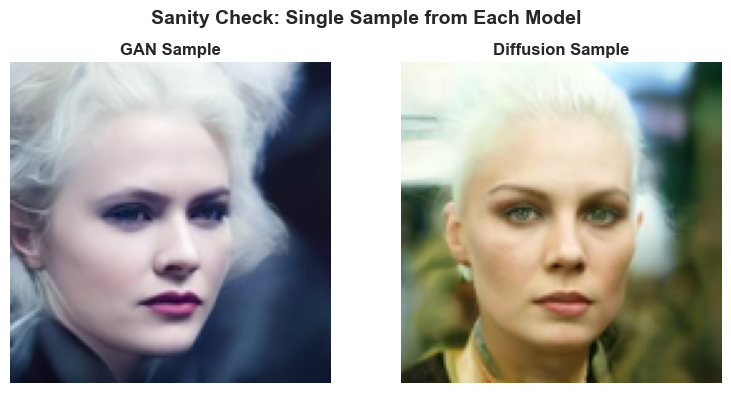

In [14]:

def generate_single_sample(model_name: str) -> Image.Image:
    """Generate one sample image for sanity check."""
    set_seed(CONFIG['seed'])  # Ensure reproducibility
    
    with torch.no_grad():
        if model_name == "GAN" and gan_pipeline is not None:
            result = gan_pipeline(
                batch_size=1,
                num_inference_steps=50
            )
            image = result.images[0]
            
        elif model_name == "Diffusion" and diffusion_pipeline is not None:
            result = diffusion_pipeline(
                batch_size=1,
                num_inference_steps=100
            )
            image = result.images[0]
        else:
            return None
        
        # Resize to target size
        image = image.resize((CONFIG['image_size'], CONFIG['image_size']), Image.Resampling.LANCZOS)
        return image

# Generate sanity check samples
sanity_samples = {}
for model_name in ["GAN", "Diffusion"]:
    print(f"\nTesting {model_name} generation...")
    try:
        sample = generate_single_sample(model_name)
        if sample is not None:
            sanity_samples[model_name] = sample
            print(f"  ✓ {model_name} generated successfully")
        else:
            print(f"  ⚠ {model_name} generation failed")
    except Exception as e:
        print(f"  ✗ {model_name} error: {e}")

# Visualize sanity check results
if sanity_samples:
    n_models = len(sanity_samples)
    fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 4))
    if n_models == 1:
        axes = [axes]
    
    for ax, (model_name, image) in zip(axes, sanity_samples.items()):
        ax.imshow(image)
        ax.set_title(f"{model_name} Sample", fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.suptitle("Sanity Check: Single Sample from Each Model", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(PROJECT_DIR / 'sanity_check_samples.png', bbox_inches='tight', dpi=150)
    plt.show()

# Generating Sample Images

## Check Model Availability

In [15]:
models_available = {
    'GAN': 'gan_pipeline' in globals() and gan_pipeline is not None,
    'Diffusion': 'diffusion_pipeline' in globals() and diffusion_pipeline is not None
}

for model_name, is_available in models_available.items():
    status = "✓ Available" if is_available else "✗ Not available"
    print(f"  {model_name}: {status}")

if not any(models_available.values()):
    raise RuntimeError("No models available. Please run Section 4 first to load the models.")


  GAN: ✓ Available
  Diffusion: ✓ Available


### Generation Config

In [16]:
N_SAMPLES = CONFIG['n_generated_per_model']
TARGET_SIZE = CONFIG['image_size']
BATCH_SIZE = CONFIG['batch_size']

print("="*70)
print("SYNTHETIC IMAGE GENERATION")
print("="*70)
print(f"Samples per model: {N_SAMPLES}")
print(f"Target resolution: {TARGET_SIZE}x{TARGET_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print("="*70 + "\n")

SYNTHETIC IMAGE GENERATION
Samples per model: 500
Target resolution: 128x128
Batch size: 16



## Helper Function for Generation

In [17]:
def generate_and_save_images(
    model,
    model_name: str,
    save_dir: Path,
    n_samples: int,
    target_size: int,
    batch_size: int = 16
):
    """
    Generate images from a model and save them to disk.
    Supports resuming from existing images - will skip already generated batches.
    
    Args:
        model: The generative model (pipeline or model object)
        model_name: Name of the model (for logging)
        save_dir: Directory to save generated images
        n_samples: Number of images to generate
        target_size: Target image size (will resize if needed)
        batch_size: Number of images per batch
    
    Returns:
        List of generated PIL Images
    """
    # Check for existing images (resume capability)
    existing_files = sorted(list(save_dir.glob(f"{model_name.lower()}_*.png")))
    n_existing = len(existing_files)
    
    if n_existing > 0:
        print(f"\n{model_name}: Found {n_existing} existing images")
        if n_existing >= n_samples:
            print(f"  ✓ Already have {n_existing}/{n_samples} images, skipping generation")
            # Load existing images and return
            generated_images = [Image.open(f) for f in existing_files[:n_samples]]
            return generated_images
        else:
            print(f"  → Resuming from image {n_existing}/{n_samples}")
    else:
        print(f"\n{model_name}: Starting fresh generation")
    
    print(f"{model_name}: Generating {n_samples - n_existing} remaining images...")
    generated_images = []
    
    # Calculate which batches we need to generate
    start_idx = n_existing
    n_batches = (n_samples - start_idx + batch_size - 1) // batch_size
    
    with torch.no_grad():
        for batch_idx in tqdm(range(n_batches), desc=f"{model_name} Generation"):
            # Calculate actual indices for this batch
            actual_batch_idx = (start_idx // batch_size) + batch_idx
            start_img_idx = start_idx + (batch_idx * batch_size)
            current_batch_size = min(batch_size, n_samples - start_img_idx)
            
            # Set seed for this batch (for reproducibility)
            # Use actual_batch_idx so we get same images regardless of resume point
            set_seed(CONFIG['seed'] + actual_batch_idx)
            
            try:
                batch_images = []
                
                if model_name in ["GAN", "Diffusion"]:
                    # Generate from Diffusion pipeline
                    pipeline = gan_pipeline if model_name == "GAN" else diffusion_pipeline
                    
                    # Adjust inference steps (GAN-style uses fewer steps)
                    n_inference_steps = 50 if model_name == "GAN" else 100
                    
                    result = pipeline(
                        batch_size=current_batch_size,
                        num_inference_steps=n_inference_steps,
                        output_type="pil"
                    )
                    
                    # Resize and collect images from this batch
                    for image in result.images:
                        if image.size != (target_size, target_size):
                            image = image.resize((target_size, target_size), Image.Resampling.LANCZOS)
                        batch_images.append(image)
                
                # Save images from this batch immediately
                for i, image in enumerate(batch_images):
                    img_idx = start_img_idx + i
                    save_path = save_dir / f"{model_name.lower()}_{img_idx:04d}.png"
                    image.save(save_path)
                
                generated_images.extend(batch_images)
                
            except Exception as e:
                print(f"  ✗ Error generating batch {actual_batch_idx}: {e}")
                continue
    
    # Load all images (existing + new) for return
    all_files = sorted(list(save_dir.glob(f"{model_name.lower()}_*.png")))
    all_images = [Image.open(f) for f in all_files[:n_samples]]
    
    print(f"✓ {model_name}: Total {len(all_images)}/{n_samples} images ready\n")
    return all_images


In [18]:
# Track all generated images
all_generated = {}

In [19]:


# 1. GAN Generation
if models_available['GAN']:
    gan_images = generate_and_save_images(
        model=gan_pipeline,
        model_name="GAN",
        save_dir=DIRS['gan'],
        n_samples=N_SAMPLES,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE
    )
    all_generated['GAN'] = gan_images
else:
    print("⚠ GAN model not loaded, skipping GAN generation\n")




GAN: Found 500 existing images
  ✓ Already have 500/500 images, skipping generation


In [20]:
# 2. Diffusion Generation
if models_available['Diffusion']:
    diffusion_images = generate_and_save_images(
        model=diffusion_pipeline,
        model_name="Diffusion",
        save_dir=DIRS['diffusion'],
        n_samples=N_SAMPLES,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE
    )
    all_generated['Diffusion'] = diffusion_images
else:
    print("⚠ Diffusion model not loaded, skipping Diffusion generation\n")


Diffusion: Found 500 existing images
  ✓ Already have 500/500 images, skipping generation


# Understanding Evaluation Metrics

In [21]:
import urllib.request
from io import BytesIO
import cv2
from PIL import ImageFilter, ImageEnhance
from scipy import linalg
import lpips
from torch_fidelity import calculate_metrics

## Preparing the A Simple Example

In [22]:
 
print("Checking toy example directory...")
n_cleaned = clean_directory(DIRS['toy'], "*.png")
if n_cleaned > 0:
    print(f"✓ Cleaned {n_cleaned} existing images\n")

# Download Option A portrait
print("Downloading portrait image from Unsplash...")
IMAGE_URL = "https://images.unsplash.com/photo-1438761681033-6461ffad8d80?w=400"

try:
    with urllib.request.urlopen(IMAGE_URL) as url:
        img_data = url.read()
    original_image = Image.open(BytesIO(img_data)).convert('RGB')
    
    # Resize to our target size for fair comparison
    original_image = original_image.resize((CONFIG['image_size'], CONFIG['image_size']), 
                                          Image.Resampling.LANCZOS)
    
    # Save original
    original_path = DIRS['toy'] / 'original.png'
    original_image.save(original_path)
    print(f"✓ Downloaded and saved original image ({CONFIG['image_size']}x{CONFIG['image_size']})")
    
except Exception as e:
    print(f"✗ Error downloading image: {e}")
    print("Using a backup approach...")
    # Could use a local image or generate a simple test pattern
    raise

Checking toy example directory...
  Cleaning 5 files from toy_example/
✓ Cleaned 5 existing images

✓ Downloaded and saved original image (128x128)


## Create Degradations

In [23]:
print("\nCreating degraded versions to test metric sensitivity...")

degradations = {}

# 1. Gaussian Blur (tests perceptual quality)
print("  Creating: Blurred version...")
blurred = original_image.filter(ImageFilter.GaussianBlur(radius=4))
blurred_path = DIRS['toy'] / 'blurred.png'
blurred.save(blurred_path)
degradations['Blurred'] = blurred

# 2. Color Shift (tests distribution/style sensitivity)
print("  Creating: Color-shifted version...")
# Convert to numpy for color manipulation
img_array = np.array(original_image).astype(np.float32)
# Shift towards warmer tones (increase red/yellow)
img_array[:, :, 0] = np.clip(img_array[:, :, 0] * 1.3, 0, 255)  # More red
img_array[:, :, 1] = np.clip(img_array[:, :, 1] * 1.1, 0, 255)  # Slight yellow
img_array[:, :, 2] = np.clip(img_array[:, :, 2] * 0.8, 0, 255)  # Less blue
color_shifted = Image.fromarray(img_array.astype(np.uint8))
color_shifted_path = DIRS['toy'] / 'color_shifted.png'
color_shifted.save(color_shifted_path)
degradations['Color Shifted'] = color_shifted

# 3. Gaussian Noise (tests robustness to artifacts)
print("  Creating: Noisy version...")
img_array = np.array(original_image).astype(np.float32)
noise = np.random.normal(0, 25, img_array.shape)  # Mean=0, std=25
noisy_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)
noisy = Image.fromarray(noisy_array)
noisy_path = DIRS['toy'] / 'noisy.png'
noisy.save(noisy_path)
degradations['Noisy'] = noisy

# 4. JPEG Compression (tests compression artifact sensitivity)
print("  Creating: Compressed version...")
compressed_path = DIRS['toy'] / 'compressed.png'
# Save with heavy JPEG compression then reload
temp_jpeg = DIRS['toy'] / 'temp_compressed.jpg'
original_image.save(temp_jpeg, 'JPEG', quality=10)  # Very low quality
compressed = Image.open(temp_jpeg).convert('RGB')
compressed.save(compressed_path)
temp_jpeg.unlink()  # Delete temporary JPEG
degradations['Compressed'] = compressed

print(f"\n✓ Created 4 degraded versions")




Creating degraded versions to test metric sensitivity...
  Creating: Blurred version...
  Creating: Color-shifted version...
  Creating: Noisy version...
  Creating: Compressed version...

✓ Created 4 degraded versions


## Visualie All Versions


Visualizing original and degraded versions...


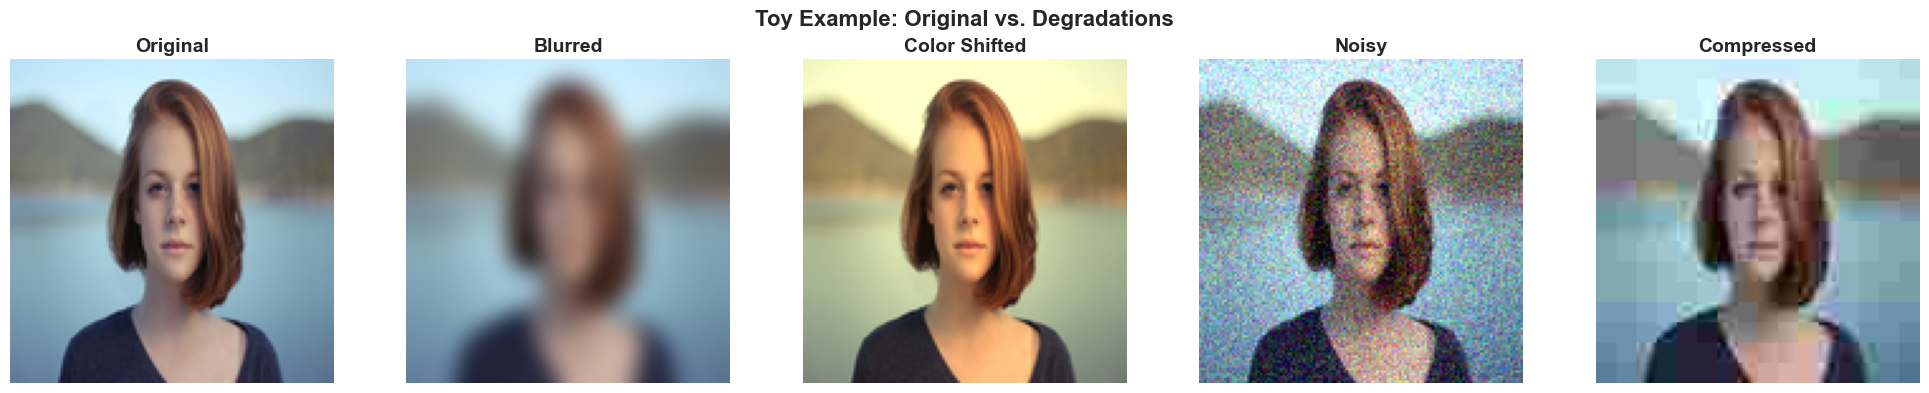

In [24]:
print("\nVisualizing original and degraded versions...")

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
all_versions = [('Original', original_image)] + list(degradations.items())

for ax, (name, img) in zip(axes, all_versions):
    ax.imshow(img)
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.axis('off')

plt.suptitle('Toy Example: Original vs. Degradations', fontsize=16, fontweight='bold')
plt.tight_layout()
vis_path = PROJECT_DIR / 'toy_example_versions.png'
plt.savefig(vis_path, bbox_inches='tight', dpi=150)
plt.show()

## Metric 1: Fréchet Inception Distance (FID)

**What FID Measures:**
FID compares the distribution of features between real and generated images.
It uses an Inception network to extract high-level features, then measures
the distance between the feature distributions using the Fréchet distance.

**How it Works:**
1. Pass images through InceptionV3 network
2. Extract feature vectors from a specific layer
3. Calculate mean (μ) and covariance (Σ) for both distributions
4. Compute: FID = ||μ₁ - μ₂||² + Tr(Σ₁ + Σ₂ - 2√(Σ₁Σ₂))

**Interpretation:**
- Lower FID = more similar distributions = better generation
- FID = 0: Identical distributions (perfect)
- FID < 10: Excellent quality
- FID 10-50: Good quality
- FID > 50: Poor quality

**Sensitivity:**
FID is sensitive to distribution-level changes (color shifts, style changes)
but may not catch individual image artifacts.

In [27]:
import warnings


def computer_toy_fid(
        original_img: Image.Image,
        degraded_img: Image.Image,
        n_copies: int=50
):
    """
    Compute FID between original and degraded image.
    Replicates images to meet minimum sample size for FID calculation.
    """
    # Create temporary directories
    temp_orig = DIRS['toy'] / 'temp_original'
    temp_deg = DIRS['toy'] / 'temp_degraded'
    temp_orig.mkdir(exist_ok=True)
    temp_deg.mkdir(exist_ok=True)
    
    # Save multiple copies (FID needs multiple samples)
    for i in range(n_copies):
        original_img.save(temp_orig / f'img_{i:03d}.png')
        degraded_img.save(temp_deg / f'img_{i:03d}.png')
    
    # Calculate FID
    metrics_dict = calculate_metrics(
        input1=str(temp_orig),
        input2=str(temp_deg),
        fid=True,
        verbose=False,
        cuda=torch.cuda.is_available(),
        batch_size=16, # Smaller batch for CPU

    )
    
    # Cleanup
    for f in temp_orig.glob('*.png'):
        f.unlink()
    for f in temp_deg.glob('*.png'):
        f.unlink()
    temp_orig.rmdir()
    temp_deg.rmdir()
    
    return metrics_dict['frechet_inception_distance']

# Compute each FID for each degradation
fid_results = {}

for name, degraded_img in degradations.items():
        try:
                
                fid_score = computer_toy_fid(original_image, degraded_img, n_copies=50)
                fid_results[name] = fid_score
                print(f"  {name:20s}: FID = {fid_score:6.2f}")
        except Exception as e:
                print(f"  ✗ Error computing FID for {name}: {e}")
                fid_results[name] = None

print("\n✓ FID computation complete")

/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(heig

  Blurred             : FID = 303.66


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(heig

  Color Shifted       : FID =  43.02


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(heig

  Noisy               : FID = 182.09


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(heig

  Compressed          : FID = 166.94

✓ FID computation complete


## Metric 2: Inception Score (IS)

**What IS Measures:**
Inception Score evaluates both the quality and diversity of generated images.
It measures how confidently an Inception network can classify images (quality)
and how diverse the predicted classes are across images (diversity).

**How it Works:**
1. Pass images through InceptionV3 network
2. Get predicted class probabilities p(y|x) for each image
3. Calculate marginal distribution p(y) across all images
4. Compute: IS = exp(E[KL(p(y|x) || p(y))])

**Interpretation:**
- Higher IS = better quality and diversity
- IS = 1: Worst (uniform distribution, no clear content)
- IS = 2-5: Poor to moderate quality
- IS = 5-10: Good quality
- IS > 10: Excellent quality

**Sensitivity:**
IS is sensitive to image clarity and recognizable content.
Less sensitive to color shifts if objects remain recognizable.

In [28]:
def compute_toy_is(image: Image.Image, n_copies: int = 50):
    """
    Compute Inception Score for an image.
    Replicates image to meet minimum sample size.
    """
    # Create temporary directory
    temp_dir = DIRS['toy'] / 'temp_is'
    temp_dir.mkdir(exist_ok=True)
    
    # Save multiple copies
    for i in range(n_copies):
        image.save(temp_dir / f'img_{i:03d}.png')
    
    # Calculate IS
    metrics_dict = calculate_metrics(
        input1=str(temp_dir),
        isc=True,
        verbose=False,
        cuda=torch.cuda.is_available()
    )
    
    # Cleanup
    for f in temp_dir.glob('*.png'):
        f.unlink()
    temp_dir.rmdir()
    
    return metrics_dict['inception_score_mean']

# Compute IS for original and each degradation
is_results = {'Original': None}
print("Computing IS scores...")

# Original
try:
    is_score = compute_toy_is(original_image, n_copies=50)
    is_results['Original'] = is_score
    print(f"  {'Original':20s}: IS = {is_score:6.2f}")
except Exception as e:
    print(f"  {'Original':20s}: Error - {e}")

# Degradations
for name, degraded_img in degradations.items():
    try:
        is_score = compute_toy_is(degraded_img, n_copies=50)
        is_results[name] = is_score
        print(f"  {name:20s}: IS = {is_score:6.2f}")
    except Exception as e:
        print(f"  {name:20s}: Error - {e}")
        is_results[name] = None

print("\n✓ IS computation complete")

Computing IS scores...


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


  Original            : IS =   1.00


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


  Blurred             : IS =   1.00


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


  Color Shifted       : IS =   1.00


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


  Noisy               : IS =   1.00


/Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)


  Compressed          : IS =   1.00

✓ IS computation complete


## Metric 3: Learned Perceptual Image Patch Similarity (LPIPS)

**What LPIPS Measures:**
LPIPS measures perceptual distance between two images using deep features
from networks trained to match human perceptual judgments. It captures
differences that humans actually notice.

**How it Works:**
1. Pass both images through a pretrained network (e.g., AlexNet, VGG)
2. Extract features from multiple layers
3. Compute weighted L2 distance between feature activations
4. Average across layers and spatial locations

**Interpretation:**
- Lower LPIPS = more perceptually similar = better
- LPIPS = 0: Identical images
- LPIPS < 0.1: Very similar
- LPIPS 0.1-0.3: Moderately similar
- LPIPS > 0.3: Very different

**Sensitivity:**
LPIPS is highly sensitive to perceptual changes humans notice:
blur, texture changes, compression artifacts, structural distortions.

In [29]:
# Initialize LPIPS model
print("Loading LPIPS model (AlexNet backbone)...")
lpips_model = lpips.LPIPS(net='alex').to(device)
print("✓ LPIPS model loaded\n")

def compute_lpips_score(img1: Image.Image, img2: Image.Image):
    """
    Compute LPIPS distance between two images.
    """
    # Convert to tensors
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    img1_tensor = transform(img1).unsqueeze(0).to(device)
    img2_tensor = transform(img2).unsqueeze(0).to(device)
    
    # Compute LPIPS
    with torch.no_grad():
        distance = lpips_model(img1_tensor, img2_tensor)
    
    return distance.item()

# Compute LPIPS for each degradation vs original
lpips_results = {}
print("Computing LPIPS scores...")

for name, degraded_img in degradations.items():
    try:
        lpips_score = compute_lpips_score(original_image, degraded_img)
        lpips_results[name] = lpips_score
        print(f"  {name:20s}: LPIPS = {lpips_score:6.4f}")
    except Exception as e:
        print(f"  {name:20s}: Error - {e}")
        lpips_results[name] = None

print("\n✓ LPIPS computation complete")


Loading LPIPS model (AlexNet backbone)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/mrla/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:33<00:00, 7.38MB/s] 


Loading model from: /Users/mrla/Documents/Projects/ai_stuffs/synthetic_image_eval/.venv/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
✓ LPIPS model loaded

Computing LPIPS scores...
  Blurred             : LPIPS = 0.5146
  Color Shifted       : LPIPS = 0.1421
  Noisy               : LPIPS = 0.4740
  Compressed          : LPIPS = 0.1618

✓ LPIPS computation complete


## Sample Results Visualizations

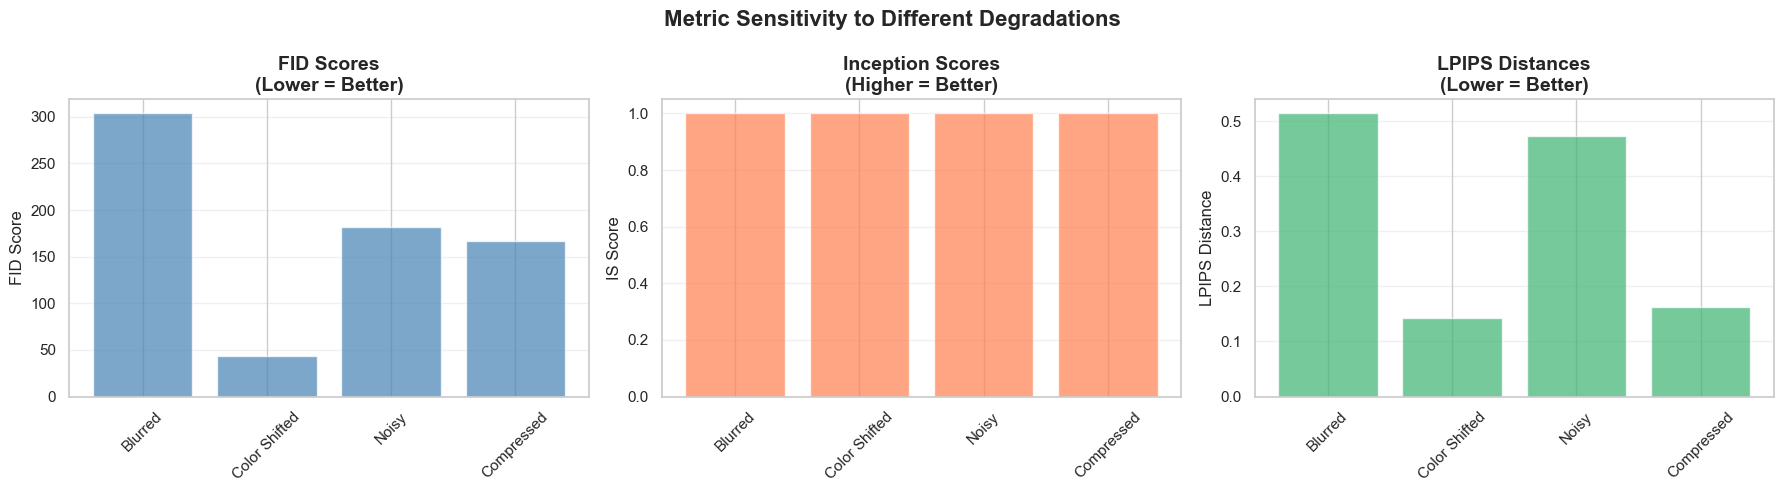

In [30]:
# Prepare data for visualization
degradation_names = list(degradations.keys())
fid_scores = [fid_results.get(name, 0) for name in degradation_names]
is_scores = [is_results.get(name, 0) for name in degradation_names]
lpips_scores = [lpips_results.get(name, 0) for name in degradation_names]

# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FID Bar Chart
axes[0].bar(degradation_names, fid_scores, color='steelblue', alpha=0.7)
axes[0].set_title('FID Scores\n(Lower = Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('FID Score', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# IS Bar Chart
axes[1].bar(degradation_names, is_scores, color='coral', alpha=0.7)
axes[1].set_title('Inception Scores\n(Higher = Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('IS Score', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# LPIPS Bar Chart
axes[2].bar(degradation_names, lpips_scores, color='mediumseagreen', alpha=0.7)
axes[2].set_title('LPIPS Distances\n(Lower = Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('LPIPS Distance', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Metric Sensitivity to Different Degradations', fontsize=16, fontweight='bold')
plt.tight_layout()

metrics_vis_path = PROJECT_DIR / 'toy_example_metrics.png'
plt.savefig(metrics_vis_path, bbox_inches='tight', dpi=150)
plt.show()

In [32]:
comparison_df = pd.DataFrame({
    'Degradation': degradation_names,
    'FID (↓)': [f"{s:.2f}" if s else "N/A" for s in fid_scores],
    'IS (↑)': [f"{s:.2f}" if s else "N/A" for s in is_scores],
    'LPIPS (↓)': [f"{s:.4f}" if s else "N/A" for s in lpips_scores]
})

print(comparison_df.to_string(index=False))
print("\nNote: ↓ means lower is better, ↑ means higher is better")

# Save to CSV
table_path = PROJECT_DIR / 'toy_example_metrics.csv'
comparison_df.to_csv(table_path, index=False)



  Degradation FID (↓) IS (↑) LPIPS (↓)
      Blurred  303.66   1.00    0.5146
Color Shifted   43.02   1.00    0.1421
        Noisy  182.09   1.00    0.4740
   Compressed  166.94   1.00    0.1618

Note: ↓ means lower is better, ↑ means higher is better


From this toy example, we can see:

1. **FID**: Sensitive to distribution-level changes
   - Responds strongly to color shifts (style changes)
   - Moderate response to structural changes

2. **Inception Score**: Measures quality AND diversity
   - ⚠️  Limited utility on single-image toy examples (all IS ≈ 1)
   - Will be more informative in Section 7 with diverse generated sets
   - Requires variety across images to measure properly

3. **LPIPS**: Captures perceptual quality
   - Highly sensitive to blur (what humans notice most)
   - Detects compression artifacts effectively
   - Strong indicator of visual quality degradation

**This is why we need all three metrics!** Each captures different aspects
of image quality. FID and LPIPS work well for comparing individual images,
while IS requires diverse sets to be meaningful.